## assignment 04: Decision Tree construction

In [ ]:
# If working in colab, uncomment the following line
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/assignment0_04_tree/tree.py -nc

In [58]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits #, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's fix the `random_state` (a.k.a. random seed).

In [59]:
RANDOM_STATE = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

### Check yourself

In [523]:
from tree import entropy, gini, variance, mad_median, DecisionTree

#### Simple check

In [524]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [525]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [526]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [534]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
accuracy_score(y_train, class_estimator.predict(X_train)), accuracy_gini, class_estimator.get_depth(class_estimator.root)

(0.9686847599164927, 0.8611111111111112, 11)

In [531]:
pathlen = []

y_predicted = []
for x in X_test[1:2]:
    counter = 0
    tree = class_estimator.root
    while tree:
        counter += 1
        print(tree.feature_index, tree.value)
        try:
            if x[tree.feature_index]<tree.value:
                tree = tree.left_child
            else:
                tree = tree.right_child
        except:
            break
    pathlen.append(counter)
    y_predicted.append(np.argmax(tree.proba))
y_predicted = np.array(y_predicted)

f'Path: {pathlen[0]}'

36 1.0
21 1.0
60 3.0
33 5.0
43 3.0
26 4.0
42 12.0
10 1.0
21 11.0
27 4.0
None None


'Path: 11'

In [535]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=10, splitter='best', criterion='gini', random_state=RANDOM_STATE, max_features=None, max_leaf_nodes=None)
dtree.fit(X_train, y_train)

y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test), dtree.get_depth(), dtree.n_classes_

(0.9686847599164927, 0.85, 10, 10)

In [536]:
clf = dtree

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 221 nodes and has the following tree structure:

node=0 is a split node with value=[[145. 154. 144. 149. 135. 135. 146. 145. 144. 140.]]: go to node 1 if X[:, 36] <= 0.5 else to node 36.
	node=1 is a split node with value=[[143.   0.   3.   1.   6.  17.   4.   0.   3.  46.]]: go to node 2 if X[:, 42] <= 5.0 else to node 13.
		node=2 is a split node with value=[[ 0.  0.  1.  1.  0. 12.  0.  0.  0. 45.]]: go to node 3 if X[:, 21] <= 6.5 else to node 8.
			node=3 is a split node with value=[[ 0.  0.  1.  0.  0. 11.  0.  0.  0.  1.]]: go to node 4 if X[:, 61] <= 11.5 else to node 5.
				node=4 is a leaf node with value=[[ 0.  0.  0.  0.  0. 11.  0.  0.  0.  0.]].
				node=5 is a split node with value=[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]: go to node 6 if X[:, 35] <= 6.5 else to node 7.
					node=6 is a leaf node with value=[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]].
					node=7 is a leaf node with value=[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]].
			node=8 is a split node with valu

In [537]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [538]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
accuracy_entropy, class_estimator.get_depth(class_estimator.root)

(0.8805555555555555, 11)

In [539]:
assert 0.84 < accuracy_gini < 0.9
assert 0.86 < accuracy_entropy < 0.9

In [540]:
val = np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference))
assert val < 1e-4, f'val is {val}'

AssertionError: val is 0.03333334444444444

In [541]:
val = np.sum(np.abs(dtree.predict_proba(X_test).mean(axis=0) - reference))
assert val < 1e-4, f'val is {val}'

AssertionError: val is 0.11331121252989626

Apparently, $10^{-4}$ is too much to ask for...

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [582]:
param_grid = {'max_depth': range(3,14), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [360]:
# for sklearn implementation
param_grid = {'max_depth': range(3,11), 'criterion': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [583]:
%%time
gs.fit(X_train, y_train)

CPU times: total: 3.67 s
Wall time: 45.2 s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 14)},
             scoring='accuracy')

In [584]:
gs.best_params_

{'criterion_name': 'gini', 'max_depth': 11}

In [585]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

AssertionError: 

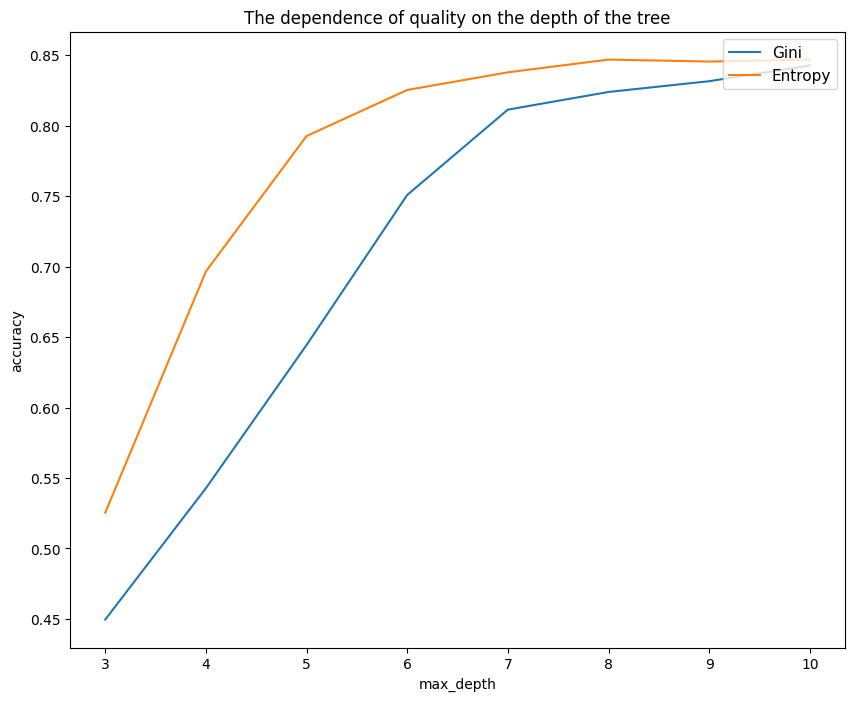

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [668]:
from sklearn.datasets import load_diabetes

In [669]:
print(load_diabetes().DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [736]:
from sklearn.datasets import fetch_openml

#boston = fetch_openml(data_id=506)
boston = fetch_openml(name='boston', version=1)
boston

C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

In [759]:
regr_data = pd.DataFrame(boston.data).to_numpy()
regr_target = pd.DataFrame(boston.target).to_numpy() # [:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

regr_data.shape, regr_target.shape

((506, 13), (506, 1))

In [760]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

19.552892156862743


In [761]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

10.622745098039218


In [772]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=10, criterion='absolute_error')
regressor.fit(RX_train, Ry_train)
ypred = regressor.predict(RX_test)
mean_squared_error(Ry_test, ypred)

30.871397058823533

In [774]:
# for sklearn

param_grid_R = {'max_depth': range(2,9), 'criterion': ['squared_error', 'absolute_error']}

gs_R = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-2,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [776]:
gs_R.best_params_

{'criterion': 'squared_error', 'max_depth': 7}

In [762]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [763]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [764]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [765]:
gs_R.best_params_

{'criterion_name': 'variance', 'max_depth': 6}

In [755]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

AssertionError: 

In [777]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

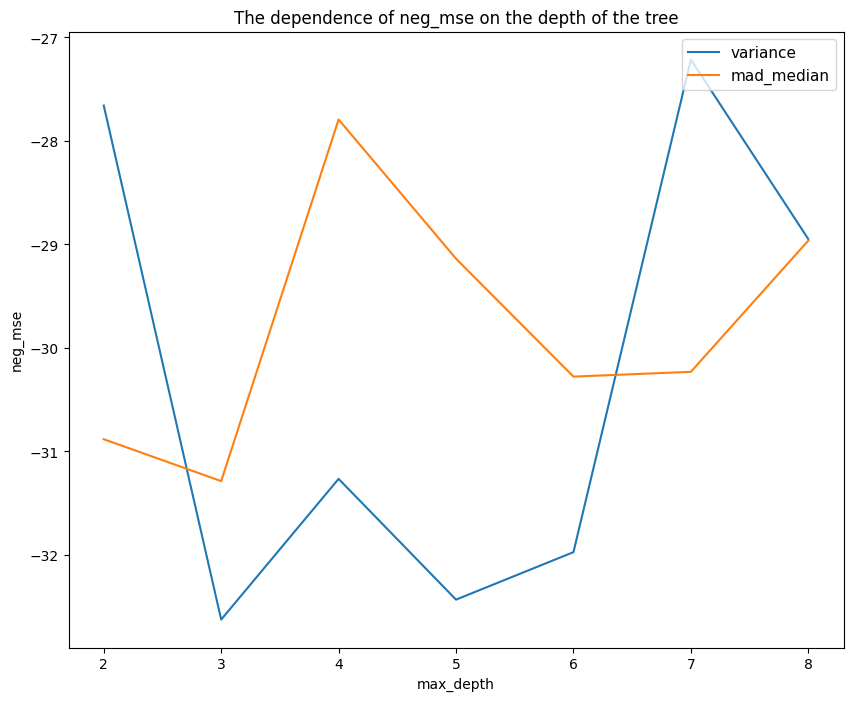

In [778]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()